# Fit transit shape

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import numpy.polynomial.polynomial as poly
import scipy.stats as stats
from   astropy.io import fits as pyfits

import sys
import os
import importlib as imp
import warnings
import argparse
import json
from   timeit import default_timer as timer

import pymc3 as pm
import pymc3_ext as pmx
import exoplanet as exo
import aesara_theano_fallback.tensor as T
from   aesara_theano_fallback import aesara as theano
from   celerite2.theano import GaussianProcess
from   celerite2.theano import terms as GPterms

from alderaan.constants import *
from alderaan.utils import *
from alderaan.Planet import *
from alderaan.LiteCurve import *
import alderaan.io as io
import alderaan.detrend as detrend

# these lines attempt to make progressbar work with SLURM 
from fastprogress.fastprogress import force_console_behavior
master_bar, progress_bar = force_console_behavior()
sys.stdout.flush()

# turn off FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

# start program timer
global_start_time = timer()

# Manually set I/O parameters
<pre>
MISSION     : can be "Kepler" or "Simulated"
TARGET      : specifies target star, format should be "K00000-00" or "S00000-00"
UMBRELLA    : can be "non-grazing", "transition", or "grazing"
PRIMARY_DIR : primary directory for progject
</pre>

In [2]:
# select mission, target, and paths
MISSION = "Kepler"
TARGET  = "K02068-00"
UMBRELLA = "transition"
PRIMARY_DIR = '/Users/research/projects/alderaan/'

if MISSION == "Kepler":
    CSV_FILE = PRIMARY_DIR + "Catalogs/cumulative_koi_catalog.csv"
    
if MISSION == "Simulated":
    CSV_FILE = PRIMARY_DIR + "Catalogs/simulated_catalog_eccentric.csv"

In [3]:
# here's where we parse the inputs
try:
    parser = argparse.ArgumentParser(description="Inputs for ALDERAAN transit fiting pipeline")
    parser.add_argument("--mission", default=None, type=str, required=True, \
                        help="Mission name")
    parser.add_argument("--target", default=None, type=str, required=True, \
                        help="Target name; see ALDERAAN documentation for acceptable formats")
    parser.add_argument("--umbrella", default=None, type=str, required=True, \
                        help="Umbrella can be 'non-grazing', 'transition', or 'grazing'")
    parser.add_argument("--primary_dir", default=None, type=str, required=True, \
                        help="Primary directory path for accessing lightcurve data and saving outputs")
    parser.add_argument("--csv_file", default=None, type=str, required=True, \
                        help="Path to .csv file containing input planetary parameters")


    args = parser.parse_args()
    MISSION     = args.mission
    TARGET      = args.target
    UMBRELLA    = args.umbrella
    PRIMARY_DIR = args.primary_dir
    CSV_FILE    = args.csv_file
    
except:
    pass

usage: ipykernel_launcher.py [-h] --mission MISSION --target TARGET --umbrella
                             UMBRELLA --primary_dir PRIMARY_DIR --csv_file
                             CSV_FILE
ipykernel_launcher.py: error: the following arguments are required: --mission, --target, --umbrella, --primary_dir, --csv_file


In [4]:
PLANET_NO = int(TARGET[-2:])
TARGET = TARGET[:6]

TARGET, PLANET_NO

('K02068', 0)

# Make sure the necessary paths exist

In [5]:
# directory in which to find lightcurve data
if MISSION == 'Kepler': DOWNLOAD_DIR = PRIMARY_DIR + 'MAST_downloads/'
if MISSION == 'Simulated': DOWNLOAD_DIR = PRIMARY_DIR + 'Simulations/'

# directories in which to place pipeline outputs
FIGURE_DIR    = PRIMARY_DIR + 'Figures/' + TARGET + '/'
TRACE_DIR     = PRIMARY_DIR + 'Traces/' + TARGET + '/'
QUICK_TTV_DIR = PRIMARY_DIR + 'QuickTTVs/' + TARGET + '/'
DLC_DIR       = PRIMARY_DIR + 'Detrended_lightcurves/' + TARGET + '/'
NOISE_DIR     = PRIMARY_DIR + 'Noise_models/' + TARGET + '/'


# check if all the paths exist and create them if not
if os.path.exists(FIGURE_DIR) == False:
    os.mkdir(FIGURE_DIR)
    
if os.path.exists(TRACE_DIR) == False:
    os.mkdir(TRACE_DIR)
    
if os.path.exists(QUICK_TTV_DIR) == False:
    os.mkdir(QUICK_TTV_DIR)
    
if os.path.exists(DLC_DIR) == False:
    os.mkdir(DLC_DIR)
    
if os.path.exists(NOISE_DIR) == False:
    os.mkdir(NOISE_DIR)

# Read in planet and stellar parameters from Kepler DR25 & Gaia DR2

In [6]:
# Read in the data from csv file
print('Reading in data from csv file')

# read in a csv file containing info on targets
csv_keys, csv_values = io.read_csv_file(CSV_FILE)

# put these csv data into a dictionary
target_dict = {}
for k in csv_keys: 
    target_dict[k] = io.get_csv_data(k, csv_keys, csv_values)

    
if MISSION == 'Kepler':
    KOI_ID = TARGET
    
elif MISSION == 'Simulated':
    KOI_ID = "K" + TARGET[1:]

else:
    raise ValueError("MISSION must be 'Kepler' or 'Simulated'")
    
    
# pull relevant quantities and establish GLOBAL variables
use = np.array(target_dict['koi_id']) == KOI_ID

KIC = np.array(target_dict['kic_id'], dtype='int')[use]
NPL = np.array(target_dict['npl'], dtype='int')[use]

PERIODS = np.array(target_dict['period'], dtype='float')[use]
EPOCHS  = np.array(target_dict['epoch'],  dtype='float')[use]
DEPTHS  = np.array(target_dict['depth'], dtype='float')[use]*1e-6          # [ppm] --> []
DURS    = np.array(target_dict['duration'], dtype='float')[use]/24         # [hrs] --> [days]

Reading in data from csv file


In [7]:
# do some consistency checks
if all(k == KIC[0] for k in KIC): KIC = KIC[0]
else: raise ValueError('There are inconsistencies with KIC in the csv input file')

if all(n == NPL[0] for n in NPL): NPL = NPL[0]
else: raise ValueError('There are inconsistencies with NPL in the csv input file')

In [8]:
# sort planet parameters by period
order = np.argsort(PERIODS)

PERIODS = PERIODS[order]
EPOCHS  = EPOCHS[order]
DEPTHS  = DEPTHS[order]
DURS    = DURS[order]
IMPACTS = 0.5*np.ones(NPL)

# Read in detrended lightcurves and initial transit time estimates
#### The data can be generated by running the script "detrend_and_estimate_noise.py"

In [9]:
# Load detrended lightcurves
try:
    lc = io.load_detrended_lightcurve(DLC_DIR + TARGET + '_lc_detrended.fits')
except:
    lc = None
    
try:
    sc = io.load_detrended_lightcurve(DLC_DIR + TARGET + '_sc_detrended.fits')
except:
    sc = None

In [10]:
# Read in QuickTTV estimates and calculate linear ephemeris for each planet
EPOCHS  = np.zeros(NPL)
PERIODS = np.zeros(NPL)

transit_inds = []
quick_transit_times = []
quick_ephemeris = []


for npl in range(NPL):
    # read in predetermined transit times
    fname_in = QUICK_TTV_DIR + TARGET + '_{:02d}'.format(npl) + '_quick.ttvs'
    data_in  = np.genfromtxt(fname_in)
    
    transit_inds.append(data_in[:,0])
    quick_transit_times.append(data_in[:,2])
    
    # do a quick fit to get a linear ephemeris
    pfit = poly.polyfit(transit_inds[npl], quick_transit_times[npl], 1)
    
    quick_ephemeris.append(poly.polyval(transit_inds[npl], pfit))
    
    EPOCHS[npl] = pfit[1]
    PERIODS[npl] = pfit[0]
    
    
# make sure transit_inds are zero-indexed
for npl in range(NPL):
    transit_inds[npl] = np.array(transit_inds[npl] - transit_inds[npl][0], dtype="int")

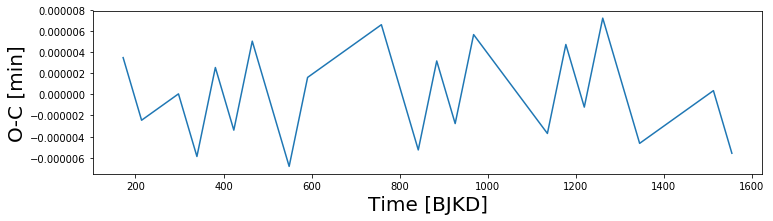

In [11]:
fig, ax = plt.subplots(NPL, figsize=(12,3*NPL))

if NPL == 1:
    ax = [ax]

for npl in range(NPL):
    xtime = quick_ephemeris[npl]
    yomc = (quick_transit_times[npl] - quick_ephemeris[npl])*24*60
    
    ax[npl].plot(xtime, yomc, '-', c='C{0}'.format(npl))
    ax[npl].set_ylabel('O-C [min]', fontsize=20)
ax[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
plt.show()

In [12]:
# determine scatter relative to linear ephemeris
# this is a deliberate overestimate of the true scatter
omc_scatter = np.zeros(NPL)

for npl in range(NPL):
    xtime = quick_ephemeris[npl]
    yomc  = quick_transit_times[npl] - quick_ephemeris[npl]
    
    omc_scatter[npl] = np.std(yomc)

# Identify overlapping transits

In [ ]:
if lc is not None:
    lc_quarters = np.unique(lc.quarter)
else:
    lc_quarters = np.array([])
    
if sc is not None:
    sc_quarters = np.unique(sc.quarter)
else:
    sc_quarters = np.array([])
    
    
quarters = np.sort(np.hstack([lc_quarters, sc_quarters]))

In [ ]:
overlap = []

for i in range(NPL):
    overlap.append(np.zeros(len(quick_ephemeris[i]), dtype='bool'))
    
    for j in range(NPL):
        if i != j:
            for tt in quick_ephemeris[j]:
                overlap[i] += np.abs(quick_ephemeris[i] - tt) < (DURS[i] + DURS[j] + lcit)

# Set fixed ephemeris and transit times

In [ ]:
fixed_ephemeris = []
fixed_transit_times = []

for npl in range(NPL):
    fixed_ephemeris.append(quick_ephemeris[npl][~overlap[npl]])
    fixed_transit_times.append(quick_transit_times[npl][~overlap[npl]])

# Set time baseline

In [ ]:
# determine the time baseline
time_min = []
time_max = []

if sc is not None:
    time_min.append(sc.time.min())
    time_max.append(sc.time.max()) 

if lc is not None:
    time_min.append(lc.time.min())
    time_max.append(lc.time.max())     

    
TIME_START = np.min(time_min)
TIME_END   = np.max(time_max)


# put epochs in range (TIME_START, TIME_START + PERIOD)
for npl in range(NPL):
    if EPOCHS[npl] < TIME_START:
        adj = 1 + (TIME_START - EPOCHS[npl])//PERIODS[npl]
        EPOCHS[npl] += adj*PERIODS[npl]        
        
    if EPOCHS[npl] > (TIME_START + PERIODS[npl]):
        adj = (EPOCHS[npl] - TIME_START)//PERIODS[npl]
        EPOCHS[npl] -= adj*PERIODS[npl]

# Track which quarter each transit falls in

In [ ]:
thresh = np.zeros(len(quarters)+1)

thresh[0] = TIME_START

for j, q in enumerate(quarters):
    if np.isin(q, sc_quarters):
        thresh[j+1] = sc.time[sc.quarter == q].max()
    if np.isin(q, lc_quarters):
        thresh[j+1] = lc.time[lc.quarter == q].max()
        
thresh[0] -= 1.0
thresh[-1] += 1.0

In [ ]:
transit_quarter = [None]*NPL

for npl in range(NPL):
    tts = fixed_ephemeris[npl]
    transit_quarter[npl] = np.zeros(len(tts), dtype='int')

    for j, q in enumerate(quarters):
        transit_quarter[npl][(tts >= thresh[j])*(tts<thresh[j+1])] = q

# Make transit masks

In [ ]:
if sc is not None:
    sc_mask = np.zeros((NPL,len(sc.time)), dtype="bool")
    for npl in range(NPL):
        sc_mask[npl] = detrend.make_transitmask(sc.time, fixed_transit_times[npl], masksize=1.5)
        
        
if lc is not None:
    lc_mask = np.zeros((NPL,len(lc.time)), dtype="bool")
    for npl in range(NPL):
        lc_mask[npl] = detrend.make_transitmask(lc.time, fixed_transit_times[npl], masksize=1.5)

# Grab the relevant data

In [ ]:
# grab data near transits for each quarter
all_time = [None]*18
all_flux = [None]*18
all_mask = [None]*18
all_dtype = ["none"]*18

lc_flux = []
sc_flux = []


for q in range(18):
    if sc is not None:
        if np.isin(q, sc.quarter):
            use = (sc_mask.sum(0) != 0)*(sc.quarter == q)

            if np.sum(use) > 45:
                all_time[q] = sc.time[use]
                all_flux[q] = sc.flux[use]
                all_mask[q] = sc_mask[:,use]
                all_dtype[q] = "short"

                sc_flux.append(sc.flux[use])
                
            else:
                all_dtype[q] = "short_no_transits"

    
    if lc is not None:
        if np.isin(q, lc.quarter):
            use = (lc_mask.sum(0) != 0)*(lc.quarter == q)

            if np.sum(use) > 5:
                all_time[q] = lc.time[use]
                all_flux[q] = lc.flux[use]
                all_mask[q] = lc_mask[:,use]
                all_dtype[q] = "long"

                lc_flux.append(lc.flux[use])
                
            else:
                all_dtype[q] = "long_no_transits"

In [ ]:
# check which quarters have data and transits
good = (np.array(all_dtype) == "short") + (np.array(all_dtype) == "long")
quarters = np.arange(18)[good]
nq = len(quarters)

seasons = np.sort(np.unique(quarters % 4))

# make some linear flux arrays (for convenience use laster)
try: sc_flux_lin = np.hstack(sc_flux)
except: sc_flux_lin = np.array([])
    
try: lc_flux_lin = np.hstack(lc_flux)
except: lc_flux_lin = np.array([])
    
try:
    good_flux = np.hstack([sc_flux_lin, lc_flux_lin])
except:
    try:
        good_flux = np.hstack(sc_flux)
    except:
        good_flux = np.hstack(lc_flux)

# Set oversampling factors and exposure times

In [ ]:
oversample = np.zeros(18, dtype="int")
texp = np.zeros(18)

oversample[np.array(all_dtype)=="short"] = 1
oversample[np.array(all_dtype)=="long"] = 15

texp[np.array(all_dtype)=="short"] = scit
texp[np.array(all_dtype)=="long"] = lcit

In [ ]:
print('')
print('cumulative runtime = ', int(timer() - global_start_time), 's')
print('')

# Define Legendre polynomials

In [ ]:
# use Legendre polynomials for better orthogonality; "x" is in the range (-1,1)
Leg0 = []
Leg1 = []
Leg2 = []
Leg3 = []
t = []

# this assumes a baseline in the range (TIME_START,TIME_END)
for npl in range(NPL):    
    t.append(fixed_ephemeris[npl])
    x = 2*(t[npl]-TIME_START)/(TIME_END-TIME_START) - 1

    Leg0.append(np.ones_like(x))
    Leg1.append(x.copy())
    Leg2.append(0.5*(3*x**2 - 1))
    Leg3.append(0.5*(5*x**3 - 3*x))

# Fit a transit model with fixed transit times

In [ ]:
for npl in range(NPL):
    if npl == PLANET_NO:
        print("PLANET", npl)

        with pm.Model() as shape_model:
            # identify which quarters and seasons have data
            which_quarters = np.unique(transit_quarter[npl])
            which_seasons = np.unique(which_quarters % 4)

            # limb darkening
            u = exo.distributions.QuadLimbDark("u", testval=[0.40,0.25])

            # radius ratio
            rmin, rmax = 1e-4, 0.99


            if UMBRELLA == "non-grazing":
                # parameters
                log_r = pm.Uniform("log_r", lower=np.log(rmin), upper=np.log(rmax), testval=np.log(0.1))
                r = pm.Deterministic("r", T.exp(log_r))
                b = pm.Uniform("b", lower=0, upper=1-r)
                g = pm.Deterministic("gamma", (1-b)/r)

                # this adjustment term makes samples uniform in the (r,b) plane
                adj = pm.Potential("adj", T.log(1-r) + T.log(r))
                
                # umbrella bias
                norm = 1/rmin - 1.5
                psi = pm.Potential("psi", T.log(T.switch(T.lt(g,2), g-1, 1.0))/norm)
                

            elif UMBRELLA == "transition":
                # parameters
                log_r = pm.Uniform("log_r", lower=np.log(rmin), upper=np.log(rmax), testval=np.log(0.1))
                r = pm.Deterministic("r", T.exp(log_r))
                g = pm.Uniform("gamma", lower=0, upper=2, testval=1.0)
                b = pm.Deterministic("b", 1-g*r)

                # Jacobian for (r,b) --> (r,gamma)
                jac = pm.Potential("jac", T.log(1/r))

                # this adjustment term makes samples uniform in the (r,b) plane
                adj = pm.Potential("adj", 2*T.log(r) + T.switch(r < 0.5, T.log(2*r), 0.0))
                
                # umbrella bias
                norm = 1.0
                psi = pm.Potential("psi", T.log(T.switch(T.lt(g,1), g, 2-g))/norm)


            elif UMBRELLA == "grazing":
                # parameters
                g = pm.Uniform("gamma", lower=-0.99, upper=1.0, testval=0.0)
                log_lam = pm.Uniform("log_lam", lower=np.log((g+1)*rmin**2), upper=np.log((g+1)*rmax**2), testval=np.log(0.01))
                lam = pm.Deterministic("lam", T.exp(log_lam))

                r = pm.Deterministic("r", pm.math.sqrt(lam/(g+1)))
                log_r = pm.Deterministic("log_r", T.log(r))
                b = pm.Deterministic("b", 1-g*r)

                # Jacobian for (r,b) --> (lambda,gamma)
                jac = pm.Potential("jac", T.log(2 + 2*g_G))

                # this adjustment term makes samples uniform in the (r,b) plane
                adj = pm.Potential("adj", -T.log(2 + 2*g_G) + 2*T.log(r_G))

                # umbrella bias
                norm = 1.0
                psi = pm.Potential("psi", T.log(T.switch(T.lt(g,0), 1+g, 1-g))/norm)

            else:
                raise ValueError("Umbrella must be 'non-grazing', 'transition', or 'grazing'")


            # enforce desired prior on (r,b)
            r_marginal = pm.Potential("r_marginal", -T.log(1+r) - T.log(r))
                
            # transit duration (sd --> assume that to 3-sigma, initial guess is correct within a factor of 2)
            log_dur = pm.Normal("log_dur", mu=np.log(DURS[npl]), sd=np.log(2)/3)
            dur = pm.Deterministic("dur", T.exp(log_dur))

            # polynomial TTV parameters (coefficients for Legendre polynomials)
            C0 = pm.Normal("C0", mu=0, sd=3*omc_scatter[npl])
            C1 = pm.Normal("C1", mu=0, sd=3*omc_scatter[npl])

            # transit times
            transit_times = pm.Deterministic("tts", fixed_transit_times[npl] + C0*Leg0[npl] + C1*Leg1[npl])

            # set up stellar model and planetary orbit
            starrystar = exo.LimbDarkLightCurve(u)
            orbit  = exo.orbits.TTVOrbit(transit_times=[transit_times], 
                                         transit_inds=[transit_inds[npl][~overlap[npl]]], 
                                         b=b, 
                                         duration=dur, 
                                         ror=r)

            # track period, epoch, and stellar density
            P = pm.Deterministic("P", orbit.period)
            T0 = pm.Deterministic("T0", orbit.t0)
            rho = pm.Deterministic("rho", orbit.rho_star)

            # mean flux and jitter
            flux0 = pm.Normal("flux0", mu=np.median(good_flux), sd=np.std(good_flux), shape=len(which_quarters))
            logjit = pm.Normal("logjit", mu=np.var(good_flux), sd=5.0, shape=len(which_quarters))

            # now evaluate the model for each quarter
            light_curves = [None]*nq
            model_flux = [None]*nq
            log_like = [None]*nq    

            for j, q in enumerate(which_quarters):
                # grab time and flux
                t_ = all_time[q][all_mask[q][npl]]
                f_ = all_flux[q][all_mask[q][npl]]

                # calculate light curves
                light_curves[j] = starrystar.get_light_curve(orbit=orbit, 
                                                             r=r, 
                                                             t=t_,
                                                             oversample=oversample[j], 
                                                             texp=texp[j])

                model_flux[j] = pm.math.sum(light_curves[j], axis=-1) + flux0[j]*T.ones(len(t_))
                #pm.Deterministic("model_flux_{0}".format(j), model_flux[j])

                # here's thelikelihood
                log_like[j] = pm.Normal("log_like_{0}".format(j), 
                                        mu=model_flux[j], 
                                        sd=T.sqrt(T.exp(logjit[j]))*T.ones(len(f_)), 
                                        observed=f_)


        with shape_model:
            shape_map = shape_model.test_point
            shape_map = pmx.optimize(start=shape_map, vars=[flux0, logjit])
            shape_map = pmx.optimize(start=shape_map, vars=[C0, C1])
            shape_map = pmx.optimize(start=shape_map, vars=[r, b, dur])        

        with shape_model:
            shape_trace = pm.sample(tune=10000, 
                                    draws=5000, 
                                    start=shape_map, 
                                    chains=2, 
                                    target_accept=0.95,
                                    init="adapt_full")

        # select which variables to save (don't save full GP or model traces or "under the hood" variables)
        varnames = []

        for i, key in enumerate(shape_map.keys()):
            skip = ("pred" in key) + ("model_flux" in key) + ("__" in key)

            if skip == False:
                varnames.append(key)

        filename = TARGET + "_{:02d}_shape_".format(npl) + UMBRELLA[0].capitalize() + ".fits"

        hdulist = io.trace_to_hdulist(shape_trace, varnames, TARGET)
        hdulist.writeto(TRACE_DIR + filename, overwrite=True)

In [ ]:
print('TOTAL RUNTIME = %.2f min' %((timer()-global_start_time)/60))